# Celltype Annotation

This tutorial shows how to use BRICK for cell type annotation based on the clustering results of scanpy. Through the differentially expressed genes of each cell cluster, we locate its corresponding cell type.

## Load packages and data 

In [2]:
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

In [219]:
adata = sc.read('../KG_annotation/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()

## Cell cluster

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


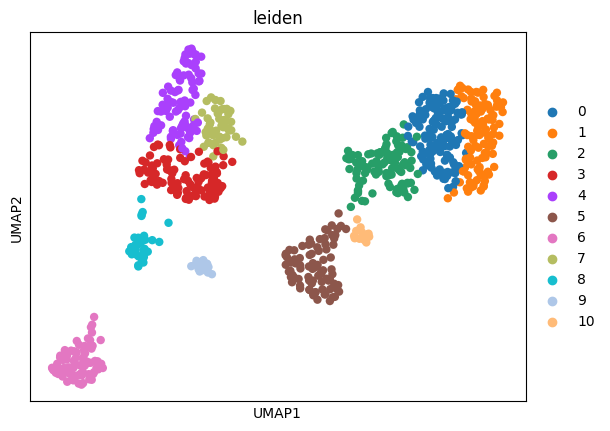

In [222]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color ='leiden')

## Differential expressed gene

In [239]:
sc.tl.rank_genes_groups(adata, groupby='leiden', pts=True)
BRICK.pp.rank_genes_groups2df(adata)

BRICK has implement a function to make the rank_genes_groups result as a dictionary where key is the cell cluster and value is a dataframe to record DEG for each cluster

In [240]:
adata.uns['rank_genes_groups_df']['0'].head()

,names,scores,pvals,pvals_adj,logfoldchanges,pts,pts_rest
names,,,,,,,
Ins2,Ins2,27.453758,1.110482e-113,1.645846e-109,2.846955,1.000000,1.000000
Ins1,Ins1,23.698265,2.015901e-85,1.493884e-81,2.595272,1.000000,0.998536
Meg3,Meg3,21.328720,1.269607e-64,4.704212e-61,3.053936,0.992806,0.396779
Chga,Chga,19.389040,4.335523e-55,8.032098e-52,2.635057,0.971223,0.554905
Pcsk2,Pcsk2,16.913595,7.432984e-48,9.180355e-45,2.165032,0.985612,0.651537


## Annotation according to the DEG

Take cell cluster 0 as example, we will show how the BRICK works to transform a gene list into a cell type

In [362]:
genelist = BRICK.pp.filter_marker(adata.uns['rank_genes_groups_df']['0'], topgenenumber=10)
genelist

['Meg3',
 'Prss53',
 'Ero1b',
 'Ptprn',
 'Neat1',
 'Chga',
 'Prlr',
 'Syt7',
 'Scg3',
 'Igf1r']

### query graph to get possible celltypes

In [366]:
query_df = BRICK.qr.query_neighbor(genelist, source_entity_type='Gene', relation='marker_of', target_entity_type='Cell')
query_df.head(3)

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.1.relation_confidence,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,maternally expressed 3<loc>:12 F1|12 60.25 cM<...,NCBI:17263,Meg3,2900016C05Rik|3110050O07Rik|6330408G06Rik|D12B...,Gene,marker_of,[MmusDv:0000008],"[AGRKB:PMID:26005002,PMID:26005002,PMID:9626496]",1,[marker_of],marker_of,[1],inner cell mass,EMAPA:16041,inner cell mass,Undef,Cell
1,maternally expressed 3<loc>:12 F1|12 60.25 cM<...,NCBI:17263,Meg3,2900016C05Rik|3110050O07Rik|6330408G06Rik|D12B...,Gene,marker_of,[MmusDv:0000012],[AGRKB:PMID:9626496],1,[marker_of],marker_of,[1],epiblast,EMAPA:16050,epiblast,primitive ectoderm,Cell
2,maternally expressed 3<loc>:12 F1|12 60.25 cM<...,NCBI:17263,Meg3,2900016C05Rik|3110050O07Rik|6330408G06Rik|D12B...,Gene,marker_of,[MmusDv:0000028],[AGRKB:MGI:4949838],1,[marker_of],marker_of,[1],renal capsule,EMAPA:18679,renal capsule,kidney capsule,Cell


### Prune parent celltype
This could be optional, we can delete parent node to make the annotation more specific. Here we only deleted the those parent nodes with only one child node

In [368]:
all_possible_cell = list(query_df['path.2.name'].unique())
parent2children = BRICK.qr.query_relation(all_possible_cell, entity_type='Cell', relation='is_a', directed=True)
parent_cells = [x for x, y in parent2children.groupby('path.2.name') if y.shape[0] == 1]
only_child_parent = parent2children.loc[parent2children['path.2.name'].isin(parent_cells)]
only_child_parent = dict(zip(only_child_parent['path.2.name'], only_child_parent['path.0.name']))
query_df['path.2.name'] = [ only_child_parent[x] if x in only_child_parent else x for x in query_df['path.2.name'] ]

### rank target entity to get the most possible celltype

In [370]:
target_df = BRICK.rk.rank_voting(query_df, metrics=['match_count', 'match_probability', 'info_source_count'])

In [371]:
target_df.sort_values('path.2.rank_voting', ascending = True).head(3)

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.match_probability,path.2.info_source_count,path.2.rank_voting
148,"[Ptprn, Prlr, Chga, Scg3, Prss53, Syt7, Ero1b,...","[marker_of, marker_of, marker_of, marker_of, m...","[2, 3, 2, 2, 3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, ...","[[1.0, 0.5449999999999999], [1.0, 0.6146, 0.69...",CL:0000168,type B pancreatic cell,Cell,10,0.039382,33,1.000000
154,"[Chga, Prlr, Ptprn, Scg3, Prss53, Syt7, Ero1b,...","[marker_of, marker_of, marker_of, marker_of, m...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[1], [1], [1], [1], [1], [1], [1], [1], [1], ...",CL:0000506,type G enteroendocrine cell,Cell,8,0.011049,24,14.500000
47,"[Chga, Meg3, Prlr, Ptprn, Scg3, Prss53, Syt7, ...","[marker_of, marker_of, marker_of, marker_of, m...","[8, 1, 1, 3, 5, 1, 1, 1]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.743000000000...",CL:0000164,enteroendocrine cell,Cell,8,0.011049,21,14.833333


According to the result, the most possible annotation for cluster 0 is type B pancreatic cell

## run cell annotation for all cell clusters 

In [358]:
import tqdm
cellcluster2celltype = {}
cellcluster2annoation_result = {}

for x, y in tqdm.tqdm(adata.uns['rank_genes_groups_df'].items()):
    genelist = BRICK.pp.filter_marker(y, topgenenumber=10)
    query_df = BRICK.qr.query_neighbor(genelist, source_entity_type='Gene', relation='marker_of', target_entity_type='Cell')
    all_possible_cell = list(query_df['path.2.name'].unique())
    parent2children = BRICK.qr.query_relation(all_possible_cell, entity_type='Cell', relation='is_a', directed=True)
    parent_cells = [x for x, y in parent2children.groupby('path.2.name') if y.shape[0] == 1]
    only_child_parent = parent2children.loc[parent2children['path.2.name'].isin(parent_cells)]
    only_child_parent = dict(zip(only_child_parent['path.2.name'], only_child_parent['path.0.name']))
    query_df['path.2.name'] = [ only_child_parent[x] if x in only_child_parent else x for x in query_df['path.2.name'] ]
    target_df = BRICK.rk.rank_voting(query_df, metrics=['match_count', 'match_probability', 'info_source_count'])
    cellcluster2annoation_result[x] = target_df.sort_values('path.2.rank_voting', ascending = True).head(5)
    cellcluster2celltype[x] = list(cellcluster2annoation_result[x]['path.2.name'])[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:25<00:00,  2.29s/it]


In [359]:
cellcluster2celltype

{'0': 'type B pancreatic cell',
 '1': 'type B pancreatic cell',
 '2': 'type D enteroendocrine cell',
 '3': 'pancreatic ductal cell',
 '4': 'epithelial cell',
 '5': 'type B pancreatic cell',
 '6': 'endothelial cell',
 '7': 'pancreatic ductal cell',
 '8': 'pancreatic stellate cell',
 '9': 'macrophage',
 '10': 'neuroendocrine cell'}

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


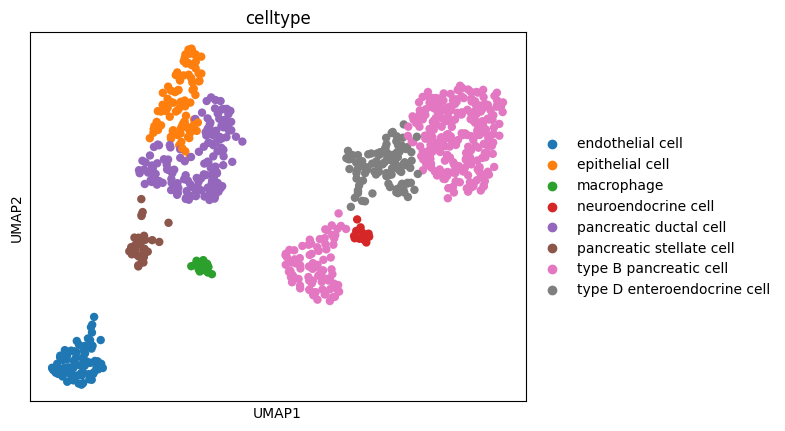

In [372]:
adata.obs['celltype'] = [cellcluster2celltype[x] for x in adata.obs['leiden']]
sc.pl.umap(adata, color = 'celltype')

## refine the result

We can not only output the top 1 cell type, but also the top 5 candidate celltype in cellcluster2annoation_result.

For instance, the cell cluster 4 is assigned as epithelial cell, which is a general cell type, we can futher look into the annotation result.


In [373]:
cellcluster2annoation_result['4']

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.match_probability,path.2.info_source_count,path.2.rank_voting
113,"[Cd14, Cldn3, Cxadr, Lcn2, Fxyd3, St3gal4, Spp...","[marker_of, marker_of, marker_of, marker_of, m...","[1, 7, 3, 2, 6, 1, 3, 1, 4]","[[1], [1.0, 1.0, 1.0, 1.0, 1.0, 0.364, 0.643],...",CL:0000066,epithelial cell,Cell,9,0.051710,28,1.000000
286,"[Spp1, Scara3, Zfp36l1, Cldn3, Cxadr, Cd14, Lc...","[marker_of, marker_of, marker_of, marker_of, m...","[2, 2, 2, 1, 1, 2, 2, 1]","[[1.0, 0.9353], [0.851, 0.6721999999999999], [...",CL:0002079,pancreatic ductal cell,Cell,8,0.028389,13,3.333333
211,"[Zfp36l1, Cxadr, Mgst1]","[marker_of, marker_of, marker_of]","[1, 8, 1]","[[1], [1, 1, 1, 1, 1, 1, 1, 1], [1]]",EMAPA:32809,main olfactory bulb,Cell,3,0.017179,10,7.833333
203,"[Cldn3, Fxyd3, Cxadr, Lcn2]","[marker_of, marker_of, marker_of, marker_of]","[2, 2, 1, 1]","[[0.833, 0.8802000000000001], [0.772, 0.705], ...",CL:0002326,luminal epithelial cell of mammary gland,Cell,4,0.008609,6,9.333333
342,"[Zfp36l1, Mgst1, Scara3, Mgst1]","[marker_of, marker_of, marker_of, marker_of]","[1, 3, 1, 1]","[[1], [1, 1, 1], [1], [1]]",CL:0000499,stromal cell of bone marrow,Cell,3,0.015000,6,10.500000


we can futher select a more specific result from other candidate cell type. 

In [374]:
BRICK.qr.query_relation(list(cellcluster2annoation_result['4']['path.2.name']), relation='is_a', entity_type='Cell', multi_hop=3, directed=True )

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,...,path.5.condition,path.5.info_source,path.5.info_source_length,path.5.original_relation,path.5.relation,path.6.def,path.6.id,path.6.name,path.6.synonym,path.6.type
0,Epithelial cell found in the ducts of the panc...,CL:0002079,pancreatic ductal cell,Undef,Cell,is_a,"[Undef, Undef, Undef]","[UBERON, UPHENO_ALL_WITH_RELATIONS, CL]",3,"[is_a, is_a, is_a]",...,"[Undef, Undef]","[UPHENO_ALL_WITH_RELATIONS, CL]",2.0,"[is_a, is_a]",is_a,A cell that is usually found in a two-dimensio...,CL:0000066,epithelial cell,epitheliocyte,Cell
1,A mammary epithelial cell that occurs in the l...,CL:0002326,luminal epithelial cell of mammary gland,mature luminal cell,Cell,is_a,[Undef],[UBERON],1,[is_a],...,"[Undef, Undef]","[UPHENO_ALL_WITH_RELATIONS, CL]",2.0,"[is_a, is_a]",is_a,A cell that is usually found in a two-dimensio...,CL:0000066,epithelial cell,epitheliocyte,Cell
2,Epithelial cell found in the ducts of the panc...,CL:0002079,pancreatic ductal cell,Undef,Cell,is_a,"[Undef, Undef, Undef]","[UBERON, UPHENO_ALL_WITH_RELATIONS, CL]",3,"[is_a, is_a, is_a]",...,"[Undef, Undef, Undef]","[UBERON, UPHENO_ALL_WITH_RELATIONS, CL]",3.0,"[is_a, is_a, is_a]",is_a,A cell that is usually found in a two-dimensio...,CL:0000066,epithelial cell,epitheliocyte,Cell
3,Epithelial cell found in the ducts of the panc...,CL:0002079,pancreatic ductal cell,Undef,Cell,is_a,"[Undef, Undef]","[UBERON, EFO]",2,"[is_a, is_a]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By querying the cell relation for each candidate cell type, we found pancreatic ductal cell is a kind of epithelial cell. Thus, we change annotation of cluster 4 into pancreatic ductal cell.

In [376]:
cellcluster2celltype['4'] = 'pancreatic ductal cell'

Similiarly, we can find out annotation for cell cluster 10 can be assigned as type B pancreatic cell as well

In [378]:
cellcluster2annoation_result['10']

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.match_probability,path.2.info_source_count,path.2.rank_voting
72,"[Syt4, Tspan7, Lrp11, Insm1, Eid1, Spcs3]","[marker_of, marker_of, marker_of, marker_of, m...","[3, 2, 5, 3, 2, 2]","[[1, 1, 1], [1, 1], [1, 1, 1, 1, 1], [1, 1, 1]...",CL:0000165,neuroendocrine cell,Cell,6,0.089478,17,1.000000
79,"[Syt4, Insm1, Eid1, Rnase4]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 2, 2]","[[1], [1], [1, 1], [1, 1]]",CL:0000323,paneth cell,Cell,4,0.045613,6,5.666667
40,"[Syt4, Lrp11, Insm1, Rnase4]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 6, 2]","[[1], [1], [1.0, 1.0, 1.0, 1.0, 1.0, 0.6179], ...",CL:0000164,enteroendocrine cell,Cell,4,0.010140,10,8.666667
77,"[Syt4, Lrp11, Insm1, Rnase4]","[marker_of, marker_of, marker_of, marker_of]","[1, 1, 1, 1]","[[1], [1], [1], [1]]",CL:0008024,pancreatic endocrine cell,Cell,4,0.010140,4,13.833333
100,"[Syt4, Lrp11, Insm1, Syt4, Lrp11, Insm1]","[marker_of, marker_of, marker_of, marker_of, m...","[3, 1, 3, 1, 1, 1]","[[1.0, 0.5524, 0.486], [1], [1.0, 0.4230000000...",CL:0000168,type B pancreatic cell,Cell,3,0.004293,10,36.166667


In [381]:
BRICK.qr.query_relation(list(cellcluster2annoation_result['10']['path.2.name']), relation='is_a', entity_type='Cell', multi_hop=3, directed=True )

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,...,path.3.condition,path.3.info_source,path.3.info_source_length,path.3.original_relation,path.3.relation,path.4.def,path.4.id,path.4.name,path.4.synonym,path.4.type
0,An endocrine cell that is part of the pancreas.,CL:0008024,pancreatic endocrine cell,Undef,Cell,is_a,"[Undef, Undef]","[UBERON, GO-PLUS]",2,"[is_a, is_a]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A cell that secretes insulin and is located to...,CL:0000169,type B pancreatic cell,B-cell of pancreatic islet|beta cell|beta cell...,Cell,is_a,"[Undef, Undef]","[UBERON, UPHENO_ALL_WITH_RELATIONS]",2,"[is_a, is_a]",...,"[Undef, Undef]","[UBERON, GO-PLUS]",2.0,"[is_a, is_a]",is_a,An endocrine cell that is located in the epith...,CL:0000164,enteroendocrine cell,Undef,Cell
2,A cell that secretes insulin and is located to...,CL:0000169,type B pancreatic cell,B-cell of pancreatic islet|beta cell|beta cell...,Cell,is_a,"[Undef, Undef]","[UBERON, UPHENO_ALL_WITH_RELATIONS]",2,"[is_a, is_a]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A cell that secretes insulin and is located to...,CL:0000169,type B pancreatic cell,B-cell of pancreatic islet|beta cell|beta cell...,Cell,is_a,"[Undef, Undef]","[UBERON, UPHENO_ALL_WITH_RELATIONS]",2,"[is_a, is_a]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [382]:
cellcluster2celltype['10'] = 'type B pancreatic cell'

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


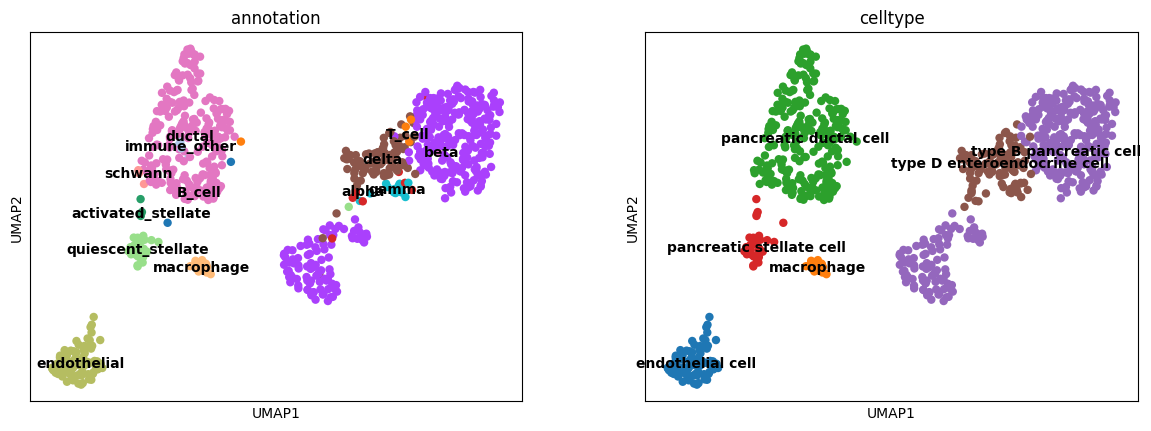

In [383]:
adata.obs['celltype'] = [cellcluster2celltype[x] for x in adata.obs['leiden']]
sc.pl.umap(adata, color =['annotation', 'celltype'], legend_loc='on data')

## Use celltype finement to futher refine the sub-celltype
Notablely, pancreatic PP cell also reached high score in cell cluster 2, which indicated this might be a sub-celltype mixture that can be further refined in Cell type refinement Tutorial.


In [384]:
cellcluster2annoation_result['2']

,path.0.name,path.1.relation,path.1.info_source_length,path.1.relation_confidence,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.match_probability,path.2.info_source_count,path.2.rank_voting
277,"[Resp18, Ptprn, Peg3, Isl1, Abcc8, Cltrn, Rbp4...","[marker_of, marker_of, marker_of, marker_of, m...","[2, 2, 2, 3, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1]","[[1.0, 0.471], [1.0, 0.45499999999999996], [1....",CL:0000172,type D enteroendocrine cell,Cell,10,0.044774,24,1.000000
200,"[Resp18, Ptprn, Peg3, Isl1, Abcc8, Cltrn, Ptpr...","[marker_of, marker_of, marker_of, marker_of, m...","[1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]","[[1], [1], [1], [1, 1, 1], [1], [1], [0.9278],...",CL:0000696,pancreatic PP cell,Cell,9,0.043611,18,2.833333
272,"[Abcc8, Resp18, Ptprn, Peg3, Isl1, Cltrn, Gpx3...","[marker_of, marker_of, marker_of, marker_of, m...","[1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1]","[[1], [1], [1], [1.0, 0.47400000000000003], [1...",CL:0000170,type A enteroendocrine cell,Cell,8,0.010278,15,4.833333
72,"[Gpx3, Isl1, Meg3, Peg3, Ptprn, Resp18, Abcc8,...","[marker_of, marker_of, marker_of, marker_of, m...","[2, 5, 1, 1, 3, 4, 1, 1]","[[1, 1], [1, 1, 1, 1, 1], [1], [1], [1, 1, 1],...",CL:0000164,enteroendocrine cell,Cell,8,0.008663,18,5.333333
201,"[Gpx3, Isl1, Meg3, Peg3, Ptprn, Resp18, Abcc8,...","[marker_of, marker_of, marker_of, marker_of, m...","[2, 1, 3, 1, 1, 3, 1, 2]","[[1.0, 0.579], [1], [1.0, 1.0, 0.27], [1], [1]...",CL:0008024,pancreatic endocrine cell,Cell,8,0.008663,14,7.833333
